# Morphing water vapor from SAPHIR
### Erfan Jahangir and Brian Mapes May 2018

Matlab codes have been used to create a set of hourly "synths" consisting of NaN-filled arrays with one orbit swath of data advected to the (hourly) target hour. 

These arrays are [241, 721) values of RH, on a half degree grid 60S-60N


---------


### General strategy of this notebook

Like any programming job, we work backward from a result-shaped container, and then forward from the most precious original data input whose value we are trying to preserve and optimize. Initially we achieve success in the simplest way, then later add sophistication -- but only to the extent it improves signal and reduces noise, as seen in the results which are fundamentally visual and thus can be evaluated smartly by eye. 

In this case, the results-shaped container is a single 1/2-degree array of 

1. **WV** (water vapor averaged over the nearest 2 times, forward and backward, from the product's nominal hour)
1. **AT** (the 'analysis tendency' of the morphing operation, representing the horizintally Lagrangian tendency in LHS terms, or more profoundly, representing the sum of all physical source-sink terms from a RHS perspective). 
1. **t_early** (the time of the earlier observation that made the above products)
1. **t_late** (the time of the later observation " " " )

------------

In [1]:
import numpy as np 
import glob             # to list available files
import scipy.io as spio # to read the .mat files
import matplotlib.pyplot as plt
import matplotlib.animation as manimation
plt.rcParams['animation.html'] = 'jshtml'
from PIL import Image
import datetime

In [2]:
%matplotlib inline 

## Step 1: Create results-shaped containers  

In [3]:
DX = 0.5 # degrees
SOUTH = -60 # Central latitudes of southern grid  cells
NORTH = 60  # " " northern " " 
WEST = 0 # Central longitude of westernmost cell
EAST = 360 # " " easternmost " 

# Build 1D spatial coordinate arrays 
NLAT = int( (NORTH-SOUTH)/DX +1)
lat = np.linspace(SOUTH, NORTH, NLAT)

NLON = int( (EAST-WEST)/DX +1)
lon = np.linspace(WEST, EAST, NLON)


# Now build containers for the results we desire
# Which order? LON,LAT? or LAT,LON? The way Matlab creates the input files
# Fill with zeros 

WV = np.zeros( (NLAT,NLON) )
AT = np.zeros( (NLAT,NLON) )

## Step 2: The things we need to fill the containers

To fill the above arrays, we will use the *time-proximity-weighted average* for WV500:  

$ WV500 = ( WV_{before}*dt_{after} + WV_{before}*dt_{after} )/(dt_{before} + dt_{after}) $ 

and the simplest *estimate of the time derivative* using the before and after observations:

$ AT500 = ( WV_{after} - WV_{before})/(dt_{before} + dt_{after}) $ 

**Thus, we need $ WV_{before}, WV_{after}, dt_{before}, dt_{after}  $**

----------------

## How to get $ WV_{before}, WV_{after}, dt_{before}, dt_{after} $ ? 

#### We need to fill _time stacks_ of product-shaped lat-lon arrays, then process them down by compositing. 

A _time stack_ is a 3D array, NLAT x NLON x (2*DTIME+1), centered on the product time (dt=0). It doesn't matter how long in time this stack extends, as long as it is long enough that **every pixel in space has a before and an after observation**. That is, the DTMAX just has to be at least as big as the longest time gap between (advected) observations. Also, the time step between the layers in the stack (one hour) just has to be short enough that we aren't wasting observations by over-writing some locations with multiple observations, subject to efficiencies (1 minute would be overkill). Since the orbit time is about 110 minutes, DTIME=19 and 1-hour stacks are chosen. 

# Fill containers, for a set of product hours

### At each hour, 

1. **Process a set of files** to get $ WV_{before}, WV_{after}, dt_{before}, dt_{after} $.
1. **Combine before and after into products** 

------------
# Set first and last times of hourly product:
------------

In [17]:
first_hour = datetime.datetime(2012,1,4,0,0) + datetime.timedelta(hours=0)
last_hour  = first_hour + datetime.timedelta(days=2)

print(first_hour.strftime('%Y%m%dT%H'), last_hour.strftime('%Y%m%dT%H'))

20120104T00 20120106T00


-----
# FUTURE (backward advected) and PAST (forward advected) 
------

In [18]:
prodtime = first_hour - datetime.datetime(1970, 1, 1) - datetime.timedelta(hours=1.8)

## First hour, future data (which has been "backward" advected) 
futurefiles_wildcard = 'Synths/*backward*' + first_hour.strftime('%Y%m%dT%H') +'*mat'
futurefiles_wildcard

'Synths/*backward*20120104T00*mat'

In [19]:
## First hour, past data (which has been "forward" advected) 
pastfiles_wildcard = 'Synths/*forward*' + first_hour.strftime('%Y%m%dT%H') +'*mat'
pastfiles_wildcard

'Synths/*forward*20120104T00*mat'

In [20]:
# glob.glob(futurefiles_wildcard) ## Order is ARBITRARY... need robust algorithm to handle that

In [21]:
def update_future_composite(futurefiles_wildcard, WV_future, minobtime): 
     
# Before calling for the first time, build these arrays like this 
# Make lat x lon containers full of NaN for the WV and minimum ob time
#    WV_future = np.zeros( (NLAT,NLON) ); WV_future.fill(np.nan)
#    minobtime = np.zeros( (NLAT,NLON) ) + 9.99e19 # huge so any obs time will be less
    
    
# Loop over files, updating arrays wherever the obtime is smaller than the existing value
    print(np.size(glob.glob(futurefiles_wildcard)), ' files')
    for idx,filename in enumerate(glob.iglob(futurefiles_wildcard), start=0):
        mat = spio.loadmat(filename, squeeze_me=True, struct_as_record=False)
        
# Extract the "synth" data and time arrays, and set -999 values to NaN
        synth = mat['synth']
        data = synth.gridded        
        data [data < 0] = np.nan
        obtime = synth.time + data*0  # this will propagate the nan values
        
# Grab the areas that are useful (that is, are the least-far in the future)
        useful = obtime < minobtime ### Ignore warings from comparing NaN to numbers. 
        WV_future[useful] = data  [useful]
        minobtime[useful] = obtime[useful]
        
    return(WV_future, minobtime + WV_future*0) # NAN mask for minobtime

In [22]:
def update_past_composite(pastfiles_wildcard, WV_past, maxobtime): 
     
# Before calling for the first time, build these arrays like this 
# Make lat x lon containers full of NaN for the WV and maximum ob time
#    WV_past   = np.zeros( (NLAT,NLON) ); WV_past.fill(np.nan)
#    maxobtime = np.zeros( (NLAT,NLON) )  # zero so any obs time will be greater
    
# Loop over files, updating arrays wherever the obtime is greater than the existing value
    print(np.size(glob.glob(pastfiles_wildcard)), ' files')
    for idx,filename in enumerate(glob.iglob(pastfiles_wildcard), start=0):
        mat = spio.loadmat(filename, squeeze_me=True, struct_as_record=False)
        
# Extract the "synth" data and time arrays, and set -999 values to NaN
        synth = mat['synth']
        data = synth.gridded        
        data [data < 0] = np.nan
        obtime = synth.time + data*0  # this will propagate the nan values
        
# Grab the areas that are useful (that is, are the least-far in the future)
        useful = obtime > maxobtime   ### Ignore warings from comparing NaN to numbers. 
        WV_past[useful]   = data  [useful]
        maxobtime[useful] = obtime[useful]
        
    return(WV_past, maxobtime + WV_past*0) # NaN mask for maxobtime

-------------
# Update future and past obs relative to product hour
## works from files in arbitrary order
-------------

11  files


//anaconda/envs/MPO624/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less
//anaconda/envs/MPO624/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less


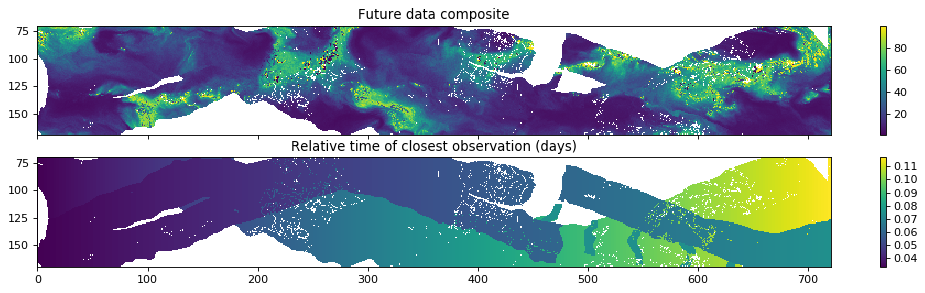

In [23]:
### FUTURE array update
WV_future = np.zeros( (NLAT,NLON) ); WV_future.fill(np.nan)
minobtime = np.zeros( (NLAT,NLON) ) + 9.99e19 # huge so any obs time will be less

WV_future, minobtime = update_future_composite(futurefiles_wildcard, WV_future, minobtime)


### Display it
fig, axarr = plt.subplots(2, sharex=True, figsize=(16, 4), dpi=80)

# WV
WV = axarr[0].imshow(WV_future)
axarr[0].set_title('Future data composite')
fig.colorbar(WV, ax=axarr[0])
# time      
tob = axarr[1].imshow(minobtime - (prodtime.days + prodtime.seconds/3600./24.))
axarr[1].set_title('Relative time of closest observation (days)')
fig.colorbar(tob, ax=axarr[1])

9  files


//anaconda/envs/MPO624/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
//anaconda/envs/MPO624/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater


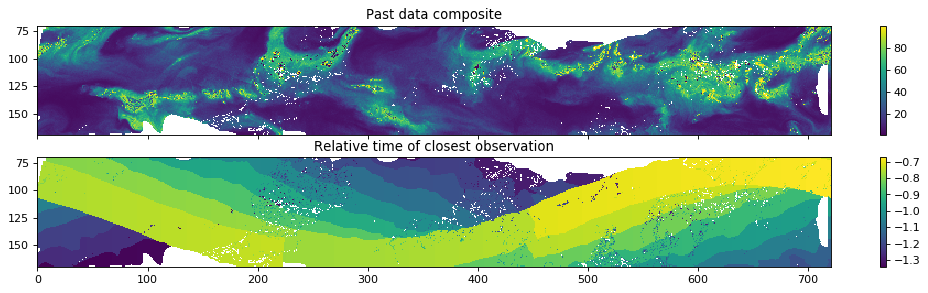

In [24]:
### update PAST arrays
WV_past = np.zeros( (NLAT,NLON) ); WV_past.fill(np.nan)
maxobtime = np.zeros( (NLAT,NLON) ) - 999. # negative, so any obs time will be greater

WV_past, maxobtime = update_past_composite(pastfiles_wildcard, WV_past, maxobtime)


### Display it
fig, axarr = plt.subplots(2, sharex=True, figsize=(16, 4), dpi=80)

# WV
WV = axarr[0].imshow(WV_past)
axarr[0].set_title('Past data composite')
fig.colorbar(WV, ax=axarr[0])
# time           
tob = axarr[1].imshow(maxobtime - (prodtime.days + prodtime.seconds/3600./24.))
axarr[1].set_title('Relative time of closest observation')
fig.colorbar(tob, ax=axarr[1])

# Combine future and past
## 1. Weighted sum: WV
## 2. d/dt, called AT (Analysis Tendency)

In [15]:
past_offset   = abs(maxobtime - prodtime.days - prodtime.seconds/3600./24.)
future_offset = abs(minobtime - prodtime.days - prodtime.seconds/3600./24.)

Text(0.5,1,'Time rate of change (Lagrangian) %/hour')

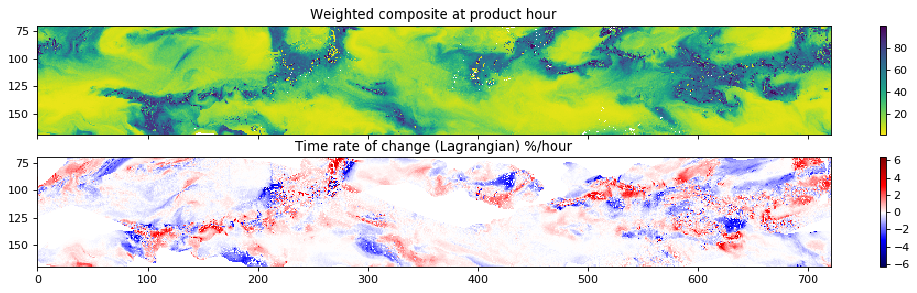

In [16]:
# Time derivative requires both values
AT = (WV_future - WV_past)/(past_offset + future_offset)


# Proximity-weighted average of the two estimates
WV = (WV_future*past_offset + WV_past*future_offset)/(past_offset + future_offset)

# Fill in the places where one estimate (future or past) is missing
WV[np.isnan(WV_future)] = WV_past  [np.isnan(WV_future)]
WV[np.isnan(WV_past  )] = WV_future[np.isnan(WV_past  )]


### Display it
fig, axarr = plt.subplots(2, sharex=True, figsize=(16, 4), dpi=80)

# WV
WVim = axarr[0].imshow(WV, cmap='viridis_r')
fig.colorbar(WVim, ax=axarr[0])
axarr[0].set_title('Weighted composite at product hour')

# time           
ATim = axarr[1].imshow(AT/24., cmap='seismic')
fig.colorbar(ATim, ax=axarr[1])
axarr[1].set_title('Time rate of change (Lagrangian) %/hour')

## Now,  how to display that as a movie?